# Assignment 04

Caroline O’Sullivan (Boston University)  
September 27, 2025

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(45)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
#print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 02:15:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#Missing Value Treatment
#1. Replace missing values in Salary by Median of Salary based on the Employment Type, if missing then replace with the overall median of Salary

from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, lit, expr, avg, median, pow
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

#select subset of columns
eda_cols = ["SALARY","MIN_YEARS_EXPERIENCE","EMPLOYMENT_TYPE_NAME","REMOTE_TYPE_NAME","STATE_NAME","MIN_EDULEVELS_NAME","COMPANY_IS_STAFFING","IS_INTERNSHIP"]
df_subset = df.select(eda_cols)

#Fix Remote Type Name incorrect labels to Remote, Hybrid, Onsite.  None and NULL are Onsite.
df_subset = df_subset.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Site")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when((col("REMOTE_TYPE_NAME").isNull()) | (col("REMOTE_TYPE_NAME") == "[None]"), "On Site")
    .otherwise("On Site")
)

#Clean Employment Type
df_subset = df_subset.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME").like("Part-time (â‰¤ 32%"), "Part Time")
    .when(col("EMPLOYMENT_TYPE_NAME").like("Part-time / full-%"), "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME").like("Full-time (> 32%"), "Full Time")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Full Time")
    .otherwise("Full Time")  # fallback for anything else
)
#Calculate the median of MIN_YEARS_EXPERIENCE column based on Employment Type
median_by_emp_type_min_exp = df.groupBy("EMPLOYMENT_TYPE").agg(expr('percentile_approx(MIN_YEARS_EXPERIENCE, 0.5)').alias('median_min_years_experience_by_emp_type'))

#Median Salary
median_salary = df_subset.approxQuantile("SALARY", [0.5], 0.25)[0]
median_by_emp_type = (
    df_subset.groupBy("EMPLOYMENT_TYPE_NAME")
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_by_emp_type"))
)

df_subset = df_subset.join(median_by_emp_type, on="EMPLOYMENT_TYPE_NAME", how="left")
df_subset = df_subset.withColumn(
    "SALARY",
    when(
        col("SALARY").isNull(),
        when(col("median_salary_by_emp_type").isNotNull(), col("median_salary_by_emp_type"))
        .otherwise(lit(median_salary))
    ).otherwise(col("SALARY"))
).drop("median_salary_by_emp_type")

#Median MIN_YEARS_EXPERIENCE
median_by_emp_type_min_exp = df.groupBy("EMPLOYMENT_TYPE_NAME").agg(
    expr('percentile_approx(MIN_YEARS_EXPERIENCE, 0.5)').alias('median_min_years_experience_by_emp_type')
)
df_subset = df_subset.join(median_by_emp_type_min_exp, on="EMPLOYMENT_TYPE_NAME", how="left")
df_subset = df_subset.withColumn(
    "MIN_YEARS_EXPERIENCE",
    when(
        col("MIN_YEARS_EXPERIENCE").isNull(),
        when(col("median_min_years_experience_by_emp_type").isNotNull(), col("median_min_years_experience_by_emp_type"))
        .otherwise(lit(0))  # fallback if needed
    ).otherwise(col("MIN_YEARS_EXPERIENCE"))
).drop("median_min_years_experience_by_emp_type")

#False for IS_INTERNSHIP and COMPANY_IS_STAFFING if NULL
df_subset = df_subset.withColumn(
    "IS_INTERNSHIP",
    when(col("IS_INTERNSHIP").isNull(), lit(False)).otherwise(col("IS_INTERNSHIP"))
).withColumn(
    "COMPANY_IS_STAFFING",
    when(col("COMPANY_IS_STAFFING").isNull(), lit(False)).otherwise(col("COMPANY_IS_STAFFING"))
)

df_subset = df_subset.withColumn("IS_INTERNSHIP_num", col("IS_INTERNSHIP").cast("int"))
df_subset = df_subset.withColumn("COMPANY_IS_STAFFING_num", col("COMPANY_IS_STAFFING").cast("int"))

df_subset = df_subset.dropna()

Linear Regression Model

In [4]:
#Feature Engineering
#String Indexing and One Hot Encoding for Categorical Variables
categorical_cols = ["EMPLOYMENT_TYPE_NAME","REMOTE_TYPE_NAME","MIN_EDULEVELS_NAME","STATE_NAME"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "COMPANY_IS_STAFFING",
        "IS_INTERNSHIP"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df_subset).transform(df_subset)

In [5]:
#Test Train Split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=45)

In [6]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.sql import Row

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3,
)

glr_model = glr.fit(train_data)
glr_summary = glr_model.summary


In [7]:
#Model Summary

print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f" Feature {i + 1}: {coef:.4f}")

Intercept: 102278.9407
Coefficients:
 Feature 1: 2378.7010
 Feature 2: -2835.2513
 Feature 3: -3435.8114
 Feature 4: 12006.3027
 Feature 5: -8290.8537
 Feature 6: 1538.9051
 Feature 7: 1088.4958
 Feature 8: -5950.0787
 Feature 9: -3615.2379
 Feature 10: -22564.1717
 Feature 11: -11979.7180
 Feature 12: 6353.9330
 Feature 13: -1553.1378
 Feature 14: 2688.0705
 Feature 15: -2274.1549
 Feature 16: 490.1882
 Feature 17: 576.8265
 Feature 18: -164.8164
 Feature 19: -1131.9933
 Feature 20: -1786.4970
 Feature 21: -2290.7826
 Feature 22: 1624.7187
 Feature 23: -2157.5368
 Feature 24: 2.7998
 Feature 25: -687.9366
 Feature 26: -2652.3943
 Feature 27: 3176.2818
 Feature 28: -1391.5348
 Feature 29: -3838.0329
 Feature 30: -2622.0994
 Feature 31: -1952.8745
 Feature 32: -1542.7176
 Feature 33: -641.1122
 Feature 34: -3499.4323
 Feature 35: -930.2304
 Feature 36: -996.0715
 Feature 37: 2871.9190
 Feature 38: -2375.4212
 Feature 39: -2173.8021
 Feature 40: -1138.4543
 Feature 41: -4351.5362
 Featur

In [8]:
#Summary Statistics
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in glr_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in glr_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in glr_summary.pValues])

Coefficient Standard Errors: ['32.1098', '345.5202', '758.5322', '998.1229', '1182.6848', '667.5953', '711.0274', '2935.8109', '2938.5952', '2974.3190', '2986.2789', '3017.8056', '3103.7287', '3105.9301', '3125.4587', '3126.0381', '3126.9004', '3129.9410', '3139.8876', '3141.4249', '3143.4861', '3143.4611', '3153.0125', '3157.2838', '3167.5916', '3177.9271', '3177.1376', '3188.2625', '3189.0496', '3192.7196', '3202.2389', '3205.5528', '3208.6622', '3227.4155', '3228.2393', '3244.4764', '3257.6197', '3281.2210', '3307.3549', '3317.3929', '3315.0877', '3323.9190', '3323.6527', '3334.4591', '3339.7964', '3331.9678', '3364.9221', '3402.6602', '3400.3004', '3395.5481', '3402.1817', '3423.3624', '3502.2973', '3560.7282', '3596.8296', '3635.7330', '3648.5880', '3711.9215', '3718.6007', '3826.0438', '3879.8121', '4034.6588', '4397.4497']
T Values: ['74.0801', '-8.2057', '-4.5296', '12.0289', '-7.0102', '2.3051', '1.5309', '-2.0267', '-1.2303', '-7.5863', '-4.0116', '2.1055', '-0.5004', '0.8655

In [9]:
#Dispersion
print(f"Null Deviance: {glr_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {glr_summary.residualDegreeOfFreedomNull}")
print(f"Residual DF: {glr_summary.residualDegreeOfFreedom}")
print(f"AIC: {glr_summary.aic:.4f}")
print(f"Deviance: {glr_summary.deviance:.4f}")

Null Deviance: 51607738345410.0703
Residual DF Null: 57956
Residual DF: 57894


AIC: 1350095.6573
Deviance: 44306505655818.4141


In [10]:
feature_names = glr_summary._call_java("featureNames")
features = ["Intercept"] + feature_names
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(glr_summary.coefficientStandardErrors)
t_values = list(glr_summary.tValues)
p_values = list(glr_summary.pValues)

print("Length of features:", len(features))
print("Length of coefficients:", len(coefs))
print("Length of standard errors:", len(se))
print("Length of t-values:", len(t_values))
print("Length of p-values:", len(p_values))

Length of features: 63
Length of coefficients: 63
Length of standard errors: 63
Length of t-values: 63
Length of p-values: 63


In [11]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

summary_df = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std. Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-value": [f"{v:.4f}" if v is not None else None for v in t_values],
    "p-value": [f"{v:.4f}" if v is not None else None for v in p_values]
})
summary_df.to_csv("output/glr_model_summary.csv", index=False)
summary_df

,Feature,Estimate,Std. Error,t-value,p-value
0,Intercept,102278.9407,32.1098,74.0801,0.0000
1,MIN_YEARS_EXPERIENCE,2378.7010,345.5202,-8.2057,0.0000
2,COMPANY_IS_STAFFING,-2835.2513,758.5322,-4.5296,0.0000
3,IS_INTERNSHIP,-3435.8114,998.1229,12.0289,0.0000
4,EMPLOYMENT_TYPE_NAME_vec_Full Time,12006.3027,1182.6848,-7.0102,0.0000
...,...,...,...,...,...
58,STATE_NAME_vec_Alaska,-7546.0152,3718.6007,0.8721,0.3831
59,STATE_NAME_vec_Vermont,3243.1689,3826.0438,0.2121,0.8320
60,STATE_NAME_vec_Montana,811.4712,3879.8121,-1.9168,0.0553
61,STATE_NAME_vec_West Virginia,-7436.7514,4034.6588,-2.7238,0.0065


In [12]:
#Create a numeric summary DataFrame for further analysis
summary_numeric = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std_Error": se,
    "t_value": t_values,
    "p_value": p_values
})

# Add significance flag
summary_numeric["Significant"] = summary_numeric["p_value"] < 0.05

# Sort by absolute t-value
summary_numeric = summary_numeric.reindex(summary_numeric["t_value"].abs().sort_values(ascending=False).index)
summary_numeric.head(10)

,Feature,Estimate,Std_Error,t_value,p_value,Significant
0,Intercept,102278.940654,32.109834,74.080141,0.000000e+00,True
62,STATE_NAME_vec_North Dakota,-10989.434042,4397.449726,23.258695,0.000000e+00,True
3,IS_INTERNSHIP,-3435.811431,998.122865,12.028883,0.000000e+00,True
1,MIN_YEARS_EXPERIENCE,2378.701045,345.520191,-8.205747,2.220446e-16,True
9,MIN_EDULEVELS_NAME_vec_No Education Listed,-3615.237936,2974.318976,-7.586332,3.330669e-14,True
4,EMPLOYMENT_TYPE_NAME_vec_Full Time,12006.302678,1182.684819,-7.010197,2.405853e-12,True
2,COMPANY_IS_STAFFING,-2835.251337,758.532194,-4.529553,5.922656e-06,True
10,MIN_EDULEVELS_NAME_vec_High school or GED,-22564.171663,2986.278876,-4.011587,6.038759e-05,True
56,STATE_NAME_vec_Hawaii,-4341.208540,3648.588031,-2.737208,6.198195e-03,True
61,STATE_NAME_vec_West Virginia,-7436.751355,4034.658810,-2.723758,6.456314e-03,True


Analysis:
I created a duplicate table and added a significance flag to better understand the model.  I then limited it by the top 10 Features by T value.  In the table above, I can see that the baseline salary in my dataset is $102,278.  The model predicts that being based in North Dakota means that you will earn $10,989 LESS in salary.  Additionally, an internship will earn you $3,435 less in salary.  When it comes to your minimum years of experience, your salary will increase by $2378 for each additional year of experience you have.  These observations are in line with what I would expect but the baseline salary is rather high in this dataset compared to national averages.

# Polynomial Regression

In [13]:
poly_data = data.withColumn("MIN_YEARS_EXPERIENCE_sq", pow(col("MIN_YEARS_EXPERIENCE"), 2))

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MIN_YEARS_EXPERIENCE_sq",
        "COMPANY_IS_STAFFING",
        "IS_INTERNSHIP"
    ] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features_poly"
)

poly_data = assembler_poly.transform(poly_data)
poly_data.select("SALARY","features_poly").show(5,truncate=False)

+--------+---------------------------------------------+
|SALARY  |features_poly                                |
+--------+---------------------------------------------+
|103573.0|(63,[0,1,5,6,8,24],[3.0,9.0,1.0,1.0,1.0,1.0])|
|86390.0 |(63,[5,6,9,17],[1.0,1.0,1.0,1.0])            |
|86390.0 |(63,[0,1,5,6,8,23],[3.0,9.0,1.0,1.0,1.0,1.0])|
|52987.0 |(63,[5,6,8,17],[1.0,1.0,1.0,1.0])            |
|86390.0 |(63,[5,7,9,21],[1.0,1.0,1.0,1.0])            |
+--------+---------------------------------------------+
only showing top 5 rows



In [14]:
#Test Train Split
train_poly_data, test_poly_data = poly_data.randomSplit([0.8, 0.2], seed=45)

In [15]:
poly_feature_names = assembler_poly.getInputCols()

poly_reg_min_yrs = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3,
)

poly_yrs_model = poly_reg_min_yrs.fit(train_poly_data)
poly_yrs_summary = poly_yrs_model.summary

In [16]:
#Model Summary

print("Intercept: {:.4f}".format(poly_yrs_model.intercept))
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_yrs_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in poly_yrs_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_yrs_summary.pValues])
print(f"Null Deviance: {poly_yrs_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_yrs_summary.residualDegreeOfFreedomNull}")
print(f"Residual DF: {poly_yrs_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_yrs_summary.aic:.4f}")
print(f"Deviance: {poly_yrs_summary.deviance:.4f}")

Intercept: 102770.4046


Coefficient Standard Errors: ['89.6343', '7.7088', '345.2028', '761.6878', '997.1704', '1181.6420', '666.9488', '710.4609', '2934.0575', '2935.7966', '2972.0945', '2983.4991', '3015.2172', '3100.7369', '3102.9532', '3122.4368', '3123.0461', '3123.8888', '3126.9238', '3136.8676', '3138.3902', '3140.4516', '3140.4866', '3149.9636', '3154.2721', '3164.5396', '3174.8576', '3174.0643', '3185.1746', '3185.9610', '3189.6462', '3199.1404', '3202.4498', '3205.5803', '3224.3000', '3225.1381', '3241.3518', '3254.4646', '3278.0500', '3304.2059', '3314.1859', '3311.9843', '3320.7134', '3320.4628', '3331.2482', '3336.5663', '3328.7495', '3361.6903', '3399.3659', '3397.0262', '3392.2679', '3398.8985', '3420.0516', '3498.9091', '3557.2962', '3593.3572', '3632.2547', '3645.0567', '3708.3337', '3715.0051', '3822.3433', '3876.0671', '4030.7522', '4393.4332']
T Values: ['16.5970', '10.6460', '-8.1069', '-5.5854', '12.0973', '-7.1567', '2.3084', '1.7295', '-1.7378', '-1.1709', '-7.3683', '-4.1078', '2.2659

Null Deviance: 51607738345410.0703
Residual DF Null: 57956
Residual DF: 57893


AIC: 1349984.3354
Deviance: 44219958881865.4297


In [17]:
poly_feature_names = poly_yrs_summary._call_java("featureNames")
poly_features = ["Intercept"] + poly_feature_names
poly_coefs = [poly_yrs_model.intercept] + list(poly_yrs_model.coefficients)
poly_se = list(poly_yrs_summary.coefficientStandardErrors)
poly_t_values = list(poly_yrs_summary.tValues)
poly_p_values = list(poly_yrs_summary.pValues)

poly_summary_df = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std. Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "t-value": [f"{v:.4f}" if v is not None else None for v in poly_t_values],
    "p-value": [f"{v:.4f}" if v is not None else None for v in poly_p_values]
})
poly_summary_df.to_csv("output/poly_model_summary.csv", index=False)
poly_summary_df

,Feature,Estimate,Std. Error,t-value,p-value
0,Intercept,102770.4046,89.6343,16.5970,0.0000
1,MIN_YEARS_EXPERIENCE,1487.6582,7.7088,10.6460,0.0000
2,MIN_YEARS_EXPERIENCE_sq,82.0679,345.2028,-8.1069,0.0000
3,COMPANY_IS_STAFFING,-2798.5163,761.6878,-5.5854,0.0000
4,IS_INTERNSHIP,-4254.3237,997.1704,12.0973,0.0000
...,...,...,...,...,...
59,STATE_NAME_vec_Alaska,-7467.6895,3715.0051,0.8537,0.3932
60,STATE_NAME_vec_Vermont,3171.6806,3822.3433,0.2298,0.8183
61,STATE_NAME_vec_Montana,878.2150,3876.0671,-1.9459,0.0517
62,STATE_NAME_vec_West Virginia,-7542.6035,4030.7522,-2.7340,0.0063


In [18]:
#Create a numeric summary DataFrame for further analysis
poly_summary_numeric = pd.DataFrame({
    "Feature": poly_features,
    "Estimate": poly_coefs,
    "Std_Error": poly_se,
    "t_value": poly_t_values,
    "p_value": poly_p_values
})

# Add significance flag
poly_summary_numeric["Significant"] = poly_summary_numeric["p_value"] < 0.05

# Sort by absolute t-value
poly_summary_numeric = poly_summary_numeric.reindex(poly_summary_numeric["t_value"].abs().sort_values(ascending=False).index)
poly_summary_numeric.head(10)

,Feature,Estimate,Std_Error,t_value,p_value,Significant
63,STATE_NAME_vec_North Dakota,-11020.259746,4393.433199,23.391821,0.000000e+00,True
0,Intercept,102770.404563,89.634274,16.596980,0.000000e+00,True
4,IS_INTERNSHIP,-4254.323692,997.170407,12.097298,0.000000e+00,True
1,MIN_YEARS_EXPERIENCE,1487.658219,7.708798,10.646001,0.000000e+00,True
2,MIN_YEARS_EXPERIENCE_sq,82.067877,345.202790,-8.106876,4.440892e-16,True
10,MIN_EDULEVELS_NAME_vec_No Education Listed,-3437.400514,2972.094524,-7.368299,1.751932e-13,True
5,EMPLOYMENT_TYPE_NAME_vec_Full Time,12063.067849,1181.641990,-7.156699,8.362200e-13,True
3,COMPANY_IS_STAFFING,-2798.516307,761.687811,-5.585390,2.342199e-08,True
11,MIN_EDULEVELS_NAME_vec_High school or GED,-21899.280992,2983.499125,-4.107798,3.999975e-05,True
62,STATE_NAME_vec_West Virginia,-7542.603506,4030.752155,-2.734045,6.258041e-03,True


Analysis:  The polynominal regression has slightly different values.  Only min years experience really changed which is the variable I squared in this model.

# Random Forest

In [19]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="SALARY", numTrees=200, maxDepth=4, seed=45)
rf_model = rf.fit(train_data.select("features","SALARY"))
rf_preds = rf_model.transform(test_data.select("features","SALARY"))

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

#Feature Importance
def get_actual_feature_names(data, assembler, encoded_cols):
    full_feature_names = []
    for col_name in assembler.getInputCols():
        if col_name in encoded_cols:
            try:
                attr_meta = data.schema[col_name].metadata["ml_attr"]["attrs"]
                for attr_group in attr_meta.values():
                    for attr in attr_group:
                        full_feature_names.append(attr["name"])
            except:
                full_feature_names.append(col_name)
        else:
            full_feature_names.append(col)
    return full_feature_names

encoded_cols = [f"{col}_vec" for col in categorical_cols]
feature_names = get_actual_feature_names(data, assembler, encoded_cols)
importances = rf_model.featureImportances.toArray()

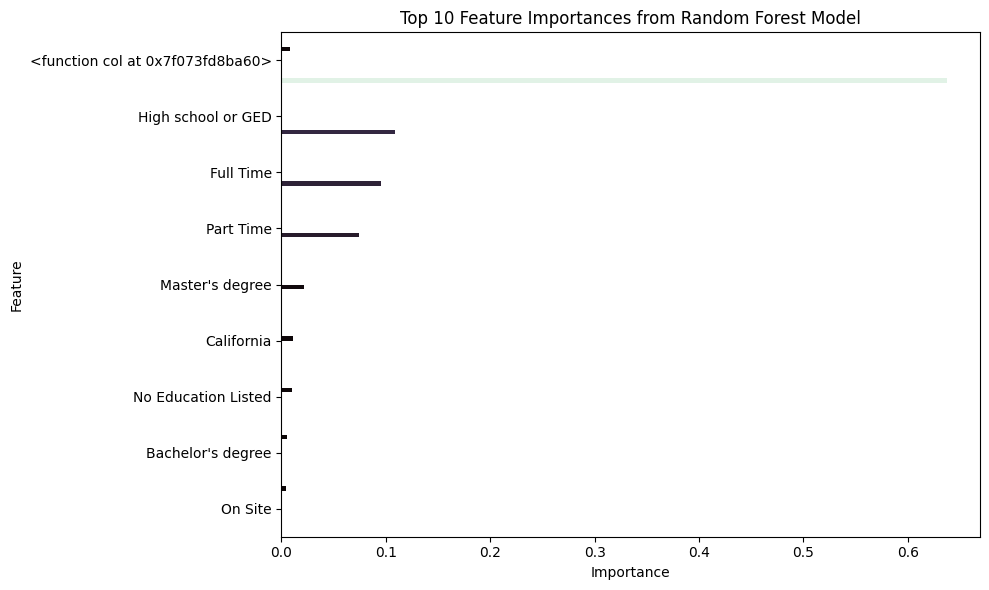

In [21]:
def clean_feature_names(feature_list):
    clean_names = []
    for name in feature_list:
        if isinstance(name, list):
            clean_names.append("_".join(str(n) for n in name))
        elif isinstance(name, str) and name.startswith("["):
            clean_names.append(name.replace("[","").replace("]","").replace("'","").replace('"','').strip())
        else:
            clean_names.append(str(name))
    return clean_names

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importance_df["Feature"] = clean_feature_names(importance_df["Feature"])

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", hue="Importance", palette="mako", legend=False)
plt.title("Top 10 Feature Importances from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("output/rf_feature_importance.png")
plt.show()    

# Compare Models

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

#Generate predications for poly and linear
poly_preds = poly_yrs_model.transform(test_poly_data)
glr_preds = glr_model.transform(test_data)
rf_preds = rf_model.transform(test_data)

evaluatorR2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
residuals_df = glr_summary.predictions.withColumn("squared_errors", pow(col("SALARY") - col("prediction"), 2))

glr_df = glr_summary.predictions.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "GLR_Prediction"})
glr_r2 = evaluatorR2.evaluate(glr_summary.predictions)
glr_rmse = np.sqrt(residuals_df.select(avg("squared_errors")).first()[0])
glr_aic = glr_summary.aic
glr_bic = len(glr_summary.coefficients) * np.log(glr_summary.numInstances) + glr_summary.numInstances * np.log(glr_summary.deviance / glr_summary.numInstances)

poly_df = poly_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "Poly_Prediction"})
poly_r2 = evaluatorR2.evaluate(poly_preds)
poly_rmse = np.sqrt(((poly_data["SALARY"] - poly_data["Poly_Prediction"]) ** 2).mean())
poly_aic = None
poly_bic = None

rf_df = rf_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "RF_Prediction"})
rf_r2 = evaluatorR2.evaluate(rf_preds)
rf_rmse = np.sqrt(((rf_df["SALARY"] - rf_df["RF_Prediction"]) ** 2).mean())
rf_aic = None
rf_bic = None

AttributeError: 'GeneralizedLinearRegressionTrainingSummary' object has no attribute 'coefficients'

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Generate predictions
poly_preds = poly_yrs_model.transform(test_poly_data)
glr_preds = glr_model.transform(test_data)
rf_preds = rf_model.transform(test_data)

# Metrics for GLR
evaluatorR2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
residuals_df = glr_summary.predictions.withColumn("squared_errors", pow(col("SALARY") - col("prediction"), 2))

glr_df = glr_summary.predictions.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "GLR_Prediction"})
glr_r2 = evaluatorR2.evaluate(glr_summary.predictions)
glr_rmse = np.sqrt(residuals_df.select(avg("squared_errors")).first()[0])
glr_aic = glr_summary.aic
glr_bic = len(glr_model.coefficients) * np.log(glr_summary.numInstances) + \
           glr_summary.numInstances * np.log(glr_summary.deviance / glr_summary.numInstances)

# Metrics for Polynomial Model
poly_df = poly_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "Poly_Prediction"})
poly_r2 = evaluatorR2.evaluate(poly_preds)
poly_rmse = np.sqrt(((poly_df["SALARY"] - poly_df["Poly_Prediction"]) ** 2).mean())
poly_aic = None
poly_bic = None

# Metrics for Random Forest
rf_df = rf_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "RF_Prediction"})
rf_r2 = evaluatorR2.evaluate(rf_preds)
rf_rmse = np.sqrt(((rf_df["SALARY"] - rf_df["RF_Prediction"]) ** 2).mean())
rf_aic = None
rf_bic = None

In [26]:
#Plot
merged = glr_df.copy()
merged["Polynomial"] = poly_df["Poly_Prediction"]
merged["Random_Forest"] = rf_df["RF_Prediction"]

#Melt
plot_df = merged.melt(id_vars="SALARY", var_name="Model", value_name="Predicted")
plot_df.head()

,SALARY,Model,Predicted
0,20800.0,GLR_Prediction,79700.536267
1,24960.0,GLR_Prediction,97928.452843
2,24960.0,GLR_Prediction,98416.110750
3,24960.0,GLR_Prediction,103947.174075
4,25480.0,GLR_Prediction,99272.377344


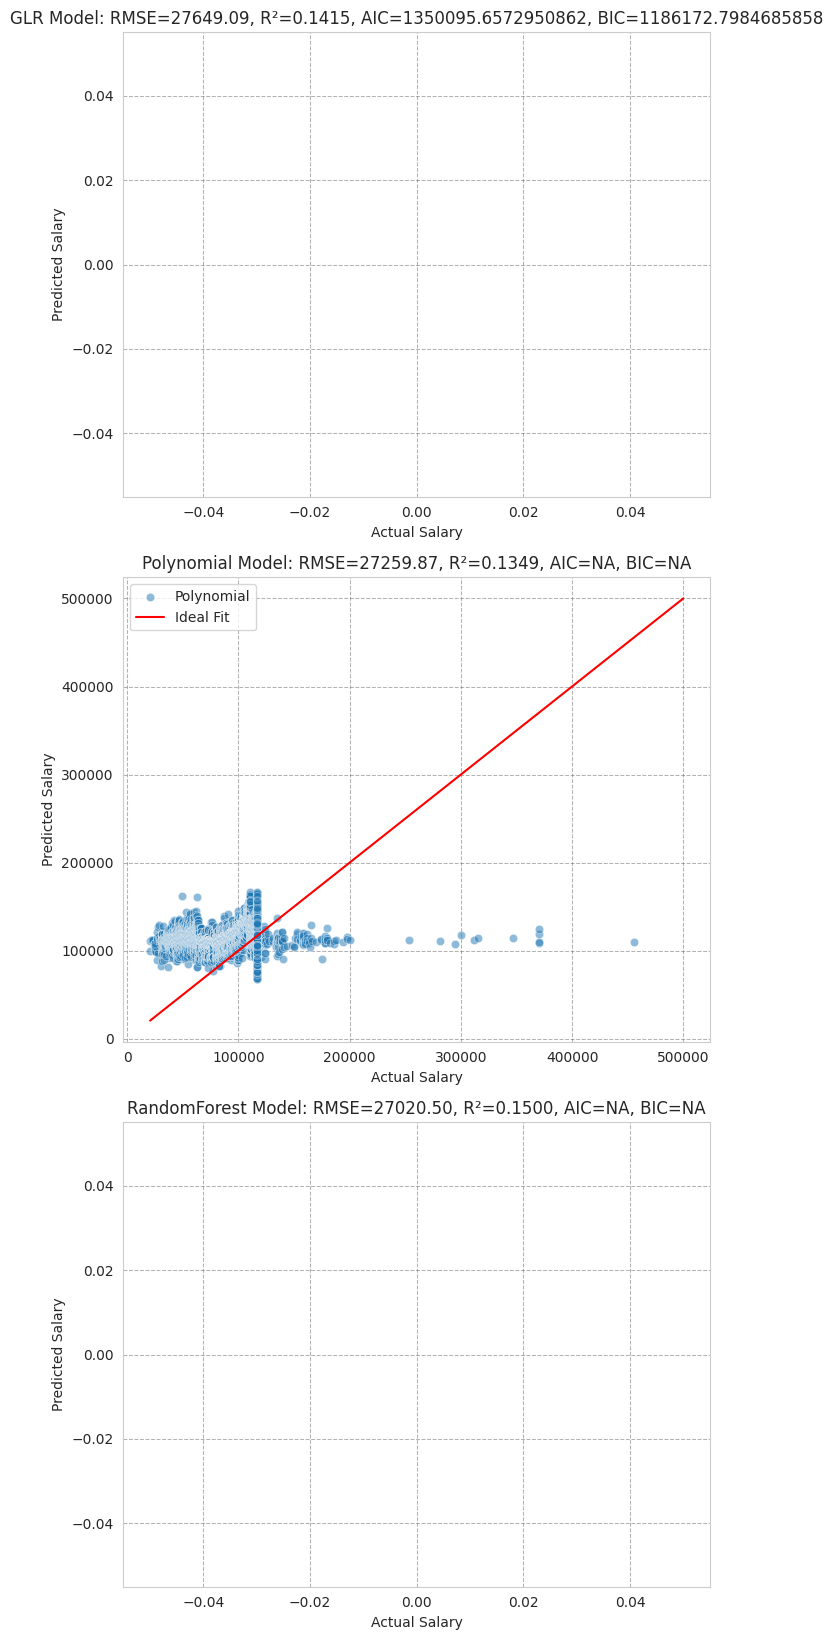

In [27]:
#Plot
plt.figure(figsize=(7,16.5))
sns.set_style("whitegrid")

models = {
    "GLR": (glr_rmse,glr_r2,glr_aic,glr_bic),
    "Polynomial": (poly_rmse,poly_r2,"NA","NA"),
    "RandomForest": (rf_rmse,rf_r2,"NA","NA")
}

for idx, model in enumerate(models.keys(), 1):
    plt.subplot(3, 1, idx)
    temp_df = plot_df[plot_df["Model"] == model]
    sns.scatterplot(data=temp_df, x="SALARY", y="Predicted", alpha=0.5, label=model)
    sns.lineplot(x=temp_df["SALARY"], y=temp_df["SALARY"], color='red', label='Ideal Fit')
    
    rmse, r2, aic, bic = models[model]
    plt.title(f"{model} Model: RMSE={models[model][0]:.2f}, R²={models[model][1]:.4f}, AIC={models[model][2]}, BIC={models[model][3]}")
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.75,color='#676767')

plt.tight_layout()
plt.savefig("output/model_comparison.png")
plt.show()